# AutoML service

In [106]:
%matplotlib inline
import json
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pprint
import requests
import seaborn as sns
from sklearn.metrics import roc_auc_score
import tsfresh

from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

import logging

## Start service

In [ ]:
! gunicorn --bind 0.0.0.0:8080 -t 0 automl_service:app

#  Prep

In [107]:
c = sns.color_palette()

In [108]:
def get_model_results(evaluated_individuals):
    """For processing model run results, store results as dictionary of AUCS"""
    tpot_results = []
    for i,(k, (steps, auc)) in enumerate(evaluated_individuals.iteritems()):
        model_type = k.split('(')[0]
        tpot_results.append([model_type, i, auc])
    return tpot_results

In [109]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [110]:
label_train = pd.read_json('data/label_train.json')
df = pd.read_json('data/data_train.json')
x_train = df.groupby('example_id').sum()
df.index = df.index.astype(np.int)
label_train = pd.read_json('data/label_train.json')

# Show raw time series data

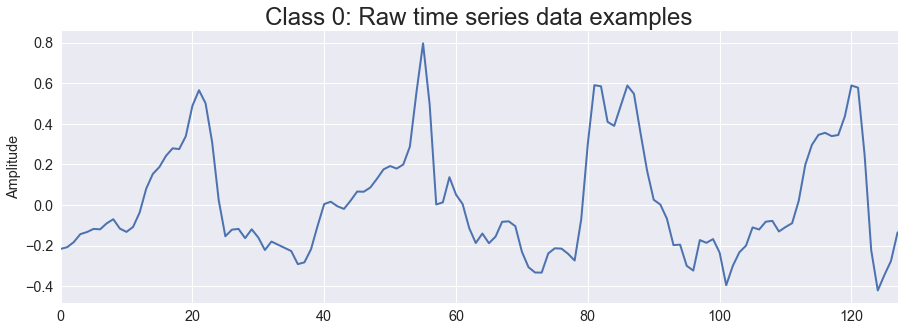

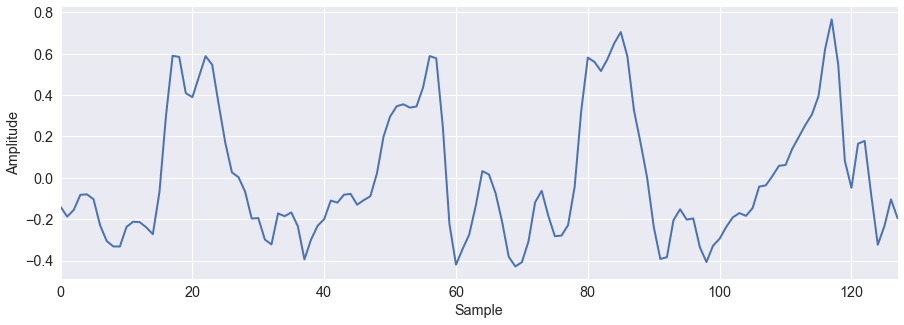

In [111]:
df = pd.read_json('data/data_train.json')
df.index = df.index.astype(int)
for i,(_,_df) in enumerate(df[df.example_id.isin([0, 1])].groupby('example_id')):
    plt.figure()
    _df.index = _df.index%128
    _df.sort_index().measurement.plot(linewidth=2, color=c[0])
    plt.ylabel('Amplitude')
    if i==0:
        plt.title('Class 0: Raw time series data examples', size=24)
plt.xlabel('Sample');

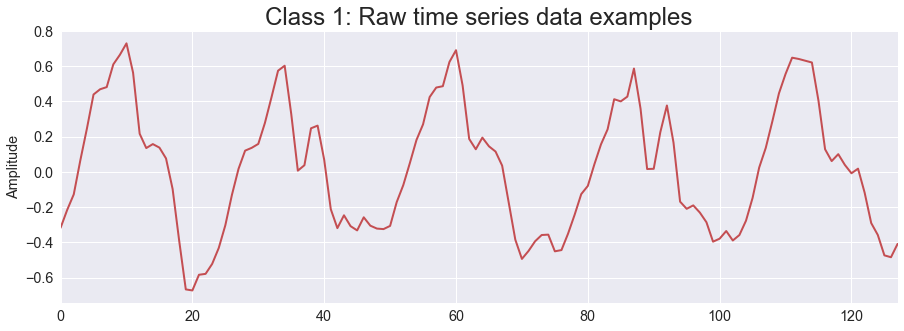

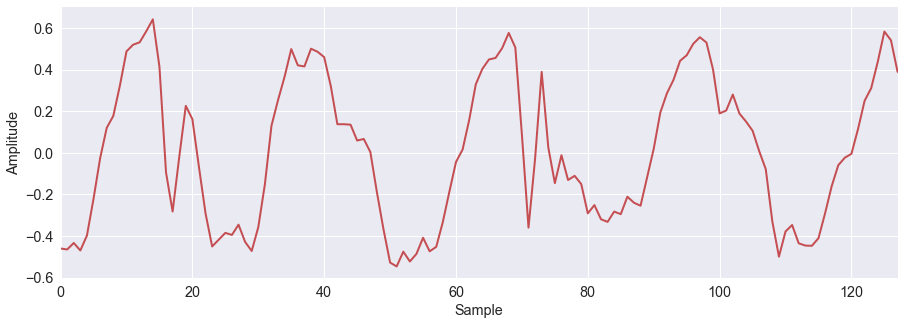

In [112]:
for i,(_,_df) in enumerate(df[df.example_id.isin([1246, 1248])].groupby('example_id')):
    plt.figure()
    _df.index = _df.index%128
    _df.sort_index().measurement.plot(linewidth=2, color=c[2])
    plt.ylabel('Amplitude')
    if i==0:
        plt.title('Class 1: Raw time series data examples', size=24)
plt.xlabel('Sample');

# Use model serve API 

### Train Model

In [115]:
train_url = 'http://0.0.0.0:8080/train_pipeline'
train_files = {'raw_data': open('data/data_train.json', 'rb'),
               'labels'  : open('data/label_train.json', 'rb'),
               'params'  : open('train_parameters_model2.yml', 'rb')}

In [116]:
r_train = requests.post(train_url, files=train_files)
result_df = json.loads(r_train.json())

In [117]:
r=requests.get('http://0.0.0.0:8080/models')
pipelines = json.loads(r.json())

automl_experiments = get_model_results(pipelines['2']['evaluated_models'])
del result_df['evaluated_models'] # too long to print out
pprint.pprint(result_df)

{u'featureEngParams': {u'column_id': u'example_id',
                       u'default_fc_parameters': u"['median', 'minimum', 'standard_deviation', 'sum_values', 'variance', 'maximum', 'length', 'mean']",
                       u'impute_function': u'impute'},
 u'mean_cv_accuracy': 0.87974166380238,
 u'mean_cv_roc_auc': 0.9586794436709594,
 u'modelId': 2,
 u'modelType': u"Pipeline(memory=None,\n     steps=[('extratreesclassifier', ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',\n           max_depth=None, max_features='auto', max_leaf_nodes=None,\n           min_impurity_decrease=0.0, min_impurity_split=None,\n           min_samples_leaf=1, min_samples_split=16,\n           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,\n           oob_score=False, random_state=None, verbose=0, warm_start=False))])",
 u'trainShape': [1647, 8],
 u'trainTime': 17.474592208862305}


(0.8, 0.89730853085679241)

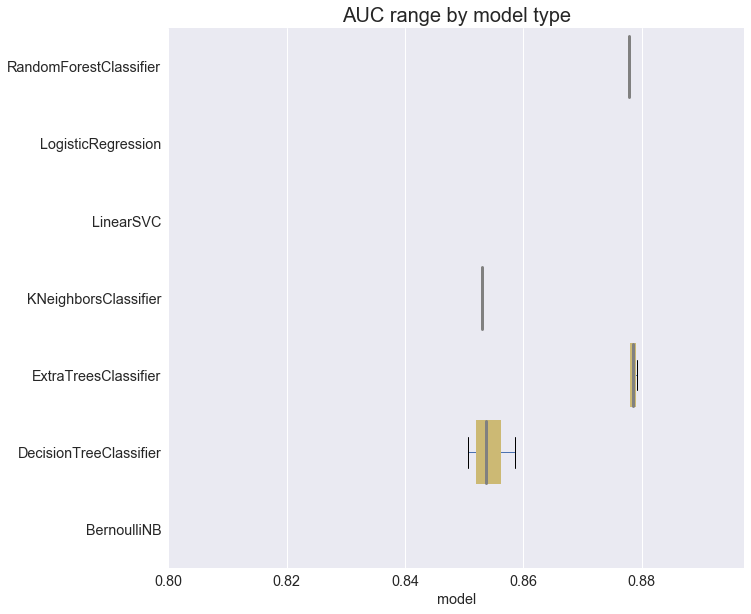

In [118]:
automl_experiments = pd.DataFrame(automl_experiments, columns=['model', 'id', 'auc']).sort_values('model')
sns.set_style(style='darkgrid')
f, ax = plt.subplots(figsize=(10,10))
box = automl_experiments.boxplot(column='auc', by='model', rot=0, vert=False,
                             ax=ax, patch_artist=True, return_type='dict',
                             widths=0.8)
ax.grid(axis='y')
ax.set_title('AUC range by model type', size=20)
plt.suptitle('')

for b in box['auc']['boxes']:
    color = sns.color_palette()[4] 
    b.set(color=color, linewidth=2)
    b.set(facecolor=color, linewidth=2)

# for median in bp['medians']:
for median in box['auc']['medians']:
    median.set(color='grey', linewidth=3)

plt.xlim(0.8)

### Serve model prediction

In [119]:
serve_url = 'http://0.0.0.0:8080/serve_prediction'
test_files = {'raw_data': open('data/data_test.json', 'rb'),
              'params' : open('test_parameters_model2.yml', 'rb')}

In [120]:
r_test  = requests.post(serve_url, files=test_files)
result = pd.read_json(r_test.json()).set_index('id')

In [121]:
result.head()

,score
id,
8,0.512259
15,0.983195
61,0.113562
559,0.922180
560,0.033397


In [122]:
label_test = pd.read_json('data/label_test.json')
result.index = result.index.astype(np.int)
result = result.loc[label_test.example_id]
auc = roc_auc_score(label_test.label, result.score)

print "AUC: {:1.2f}".format(auc)

AUC: 0.95


# Appendix

## Build an AutoML Pipeline

## Load Data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying). We use only two labels to create a binary classification problem for demonstration purposes.

The dataset is available here: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [123]:
# fetch dataset from uci
download_har_dataset()

In [124]:
# load data
df = load_har_dataset()
y = load_har_classes()

# binary classification
class1, class2 = 2, 3
two_classes = (y==class1) | (y==class2)
df = df[two_classes]
y = y[two_classes]
# change lavel names
y[y==class1] = 0
y[y==class2] = 1
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

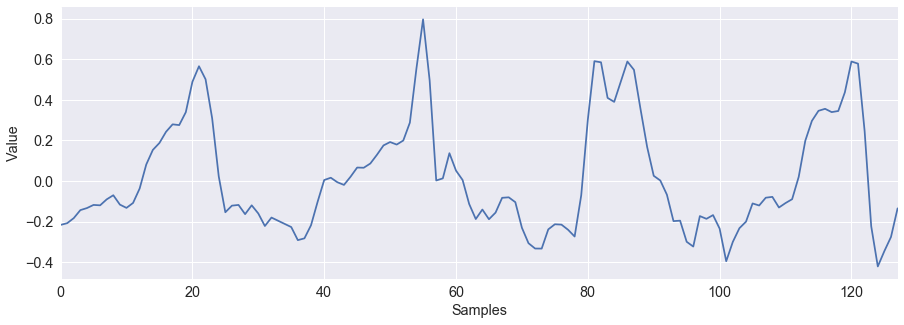

In [125]:
df.loc[0].plot()
plt.xlabel('Samples')
plt.ylabel('Value');

## Prep data for feature building
We need to get the data in the format required by TSFRESH:

If there are 100 examples, where each example has 50 samples, we need to go from a (100, 50) dataframe to a (100*50, 2) dataframe as follows:
~~~
measurement|example_id
----------------------
0.5235     |0
0.4284     |0
0.9042     |0
...
0.9042     |100
~~~
See the TSFRESH docs for more details

In [126]:
# values
v = df.stack().values

# ids
ids = []
for i in range(len(y)):
    ids.extend(128*[i])
ids = np.array(ids)

master_df = pd.DataFrame(v, columns=['measurement'])
master_df['example_id'] = ids

## Build Train/Test Set

In [127]:
# build label dataframe
label_df = pd.DataFrame(y.reset_index(drop=True))\
    .reset_index()
label_df.columns = ['example_id', 'label']

# split into training and test 
train_id, test_id = train_test_split(label_df.example_id, random_state=43, test_size=0.2)
train_id = pd.DataFrame(train_id)
test_id  = pd.DataFrame(test_id)

data_train = master_df.merge(train_id, on='example_id')
data_test = master_df.merge(test_id, on='example_id')
print float(data_train.shape[0])/(data_train.shape[0] + data_test.shape[0])

label_train = label_df.merge(train_id, on='example_id')
label_test = label_df.merge(test_id, on='example_id')

0.799902865469


## Build a model

In [128]:
%%time

extraction_settings = MinimalFCParameters()

X_train = extract_features(data_train, column_id='example_id', impute_function=eval('tsfresh.utilities.dataframe_functions.impute'), default_fc_parameters=extraction_settings); 
X_test  = extract_features(data_test, column_id='example_id', impute_function=impute, default_fc_parameters=extraction_settings);

Feature Extraction: 100%|██████████| 412/412 [00:00<00:00, 5401.15it/s]


CPU times: user 579 ms, sys: 180 ms, total: 759 ms
Wall time: 792 ms


In [129]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score
tpot = TPOTClassifier(generations=5, population_size=20, max_time_mins=0.2)
tpot.fit(X_train, label_train.label)
roc_auc_score(label_test.label, tpot.predict_proba(X_test)[:,1])

0.92923632218844987

### Compare to Random Forest (baseline)

In [131]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier(n_estimators=100, n_jobs=-1)
cl.fit(X_train, label_train.label)
roc_auc_score(label_test.label, cl.predict_proba(X_test)[:,1])
import sklearn
scoring = ['roc_auc', 'accuracy']
cv = sklearn.model_selection.cross_validate(cl, X_train, label_train.label, cv=5, scoring=scoring)
mean_accuracy = cv['test_accuracy'].mean()
mean_roc_auc = cv['test_roc_auc'].mean()
mean_accuracy, mean_roc_auc

(0.87729527089412929, 0.95033028910458905)

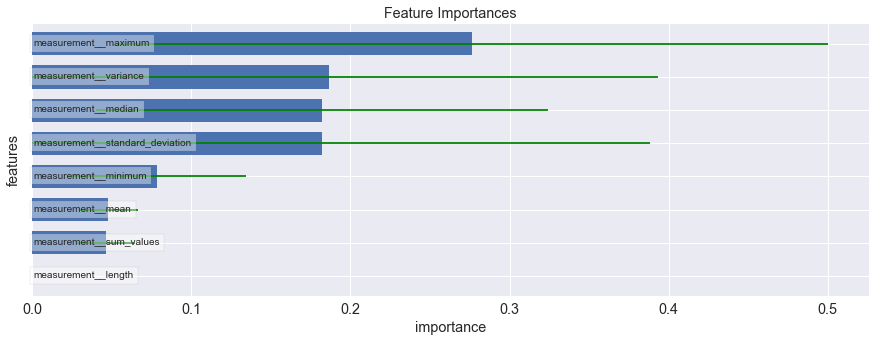

In [132]:
def plot_importances(cl, column_names, n_features=10, ax=None, error_bars = True):
    df_imp = pd.DataFrame({'features': column_names,
                           'importances': cl.feature_importances_})
    errors = np.std([tree.feature_importances_ for tree in cl.estimators_], axis=0)
    df_imp_sub = df_imp.set_index('features').sort_values('importances').tail(n_features)
    if error_bars:
        df_errors = pd.DataFrame({'features': column_names,
                                  'importances': errors})
        df_err_sub = df_errors.set_index('features').loc[df_imp_sub.index]
    else:
        df_err_sub = None
    ax = df_imp_sub.plot(kind='barh', width=.7, legend=False, ax=ax, xerr=df_err_sub, ecolor='g')
    for i,t in enumerate(df_imp_sub.index.tolist()):
        t = ax.text(0.001, i-.06,t)
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='grey'))
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Feature Importances')
    ax.set_xlim(0.0)
    ax.set_xlabel('importance')
    return df_imp_sub

plot_importances(cl, X_train.columns);

## Export Data
Save training/testing data so we can build and test the AutoML Flask service

In [133]:
# import os
# output_dir = 'data'
# data_train.to_json(os.path.join(output_dir, 'data_train.json'))
# data_test.to_json(os.path.join(output_dir, 'data_test.json'))
# label_train.to_json(os.path.join(output_dir, 'label_train.json'))
# label_test.to_json(os.path.join(output_dir, 'label_test.json'))

IOError: [Errno 2] No such file or directory: 'automl_service/data/data_train.json'